##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-quant-finance

In [ ]:
!pip install QuantLib-Python

     |████████████████████████████████| 20.1 MB 62.7 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
# tf.compat.v1.disable_eager_execution()
from typing import Any, Dict, List, Tuple, Union, Optional
import dataclasses
from tf_quant_finance import datetime as dates
from tf_quant_finance.models import generic_ito_process
from tf_quant_finance.math import piecewise
from tf_quant_finance.math import random

from tf_quant_finance.math import gradient
from tf_quant_finance.models import euler_sampling
from tf_quant_finance.models import utils
from tf_quant_finance.models.hjm import quasi_gaussian_hjm
from tf_quant_finance.math.interpolation.linear import interpolate
from tf_quant_finance.math.pde import fd_solvers

import matplotlib.pyplot as plt

# HJM Model

In [ ]:
class GaussianHJM(quasi_gaussian_hjm.QuasiGaussianHJM):
  r"""Gaussian HJM model for term-structure modeling.

  Heath-Jarrow-Morton (HJM) model for the interest rate term-structre
  modelling specifies the dynamics of the instantaneus forward rate `f(t,T)`
  with maturity `T` at time `t` as follows:

  ```None
    df(t,T) = mu(t,T) dt + sum_i sigma_i(t,  T) * dW_i(t),
    1 <= i <= n,
  ```
  where `mu(t,T)` and `sigma_i(t,T)` denote the drift and volatility
  for the forward rate and `W_i` are Brownian motions with instantaneous
  correlation `Rho`. The model above represents an `n-factor` HJM model.
  The Gaussian HJM model assumes that the volatility `sigma_i(t,T)` is a
  deterministic function of time (t). Under the risk-neutral measure, the
  drift `mu(t,T)` is computed as

  ```
    mu(t,T) = sum_i sigma_i(t,T)  int_t^T sigma_(t,u) du
  ```
  Using the separability condition, the HJM model above can be formulated as
  the following Markovian model:

  ```None
    sigma(t,T) = sigma(t) * h(T)    (Separability condition)
  ```
  A common choice for the function h(t) is `h(t) = exp(-kt)`. Using the above
  parameterization of sigma(t,T), we obtain the following Markovian
  formulation of the HJM model [1]:

  ```None
    HJM Model
    dx_i(t) = (sum_j [y_ij(t)] - k_i * x_i(t)) dt + sigma_i(t) dW_i
    dy_ij(t) = (rho_ij * sigma_i(t)*sigma_j(t) - (k_i + k_j) * y_ij(t)) dt
    r(t) = sum_i x_i(t) + f(0, t)
  ```
  where `x` is an `n`-dimensional vector and `y` is an `nxn` dimensional
  matrix. For Gaussian HJM model, the quantity `y_ij(t)` can be computed
  analytically as follows:

  ```None
    y_ij(t) = rho_ij * exp(-k_i * t) * exp(-k_j * t) *
              int_0^t exp((k_i+k_j) * s) * sigma_i(s) * sigma_j(s) ds
  ```

  The Gaussian HJM class implements the model outlined above by simulating the
  state `x(t)` while analytically computing `y(t)`.

  The price at time `t` of a zero-coupon bond maturing at `T` is given by
  (Ref. [1]):

  ```None
  P(t,T) = P(0,T) / P(0,t) *
           exp(-x(t) * G(t,T) - 0.5 * y(t) * G(t,T)^2)
  ```

  The HJM model implementation supports constant mean-reversion rate `k` and
  `sigma(t)` can be an arbitrary function of `t`. We use Euler discretization
  to simulate the HJM model.

  #### Example. Simulate a 4-factor HJM process.

  ```python
  import numpy as np
  import tensorflow.compat.v2 as tf
  import tf_quant_finance as tff

  dtype = tf.float64
  def discount_fn(x):
    return 0.01 * tf.ones_like(x, dtype=dtype)

  process = tff.models.hjm.GaussianHJM(
      dim=4,
      mean_reversion=[0.03, 0.01, 0.02, 0.005],  # constant mean-reversion
      volatility=[0.01, 0.011, 0.015, 0.008],  # constant volatility
      initial_discount_rate_fn=discount_fn,
      dtype=dtype)
  times = np.array([0.1, 1.0, 2.0, 3.0])
  short_rate_paths, discount_paths, _, _ = process.sample_paths(
      times,
      num_samples=100000,
      time_step=0.1,
      random_type=tff.math.random.RandomType.STATELESS_ANTITHETIC,
      seed=[1, 2],
      skip=1000000)
  ```

  #### References:
    [1]: Leif B. G. Andersen and Vladimir V. Piterbarg. Interest Rate Modeling.
    Volume II: Term Structure Models.
  """

  def __init__(self,
               dim,
               mean_reversion,
               volatility,
               initial_discount_rate_fn,
               corr_matrix=None,
               dtype=None,
               name=None):
    """Initializes the HJM model.

    Args:
      dim: A Python scalar which corresponds to the number of factors comprising
        the model.
      mean_reversion: A real positive `Tensor` of shape `[dim]`. Corresponds to
        the mean reversion rate of each factor.
      volatility: A real positive `Tensor` of the same `dtype` and shape as
        `mean_reversion` or a callable with the following properties: (a)  The
          callable should accept a scalar `Tensor` `t` and returns a 1-D
          `Tensor` of shape `[dim]`. The function returns instantaneous
          volatility `sigma(t)`. When `volatility` is specified is a real
          `Tensor`, each factor is assumed to have a constant instantaneous
          volatility. Corresponds to the instantaneous volatility of each
          factor.
      initial_discount_rate_fn: A Python callable that accepts expiry time as a
        real `Tensor` of the same `dtype` as `mean_reversion` and returns a
        `Tensor` of shape `input_shape`. Corresponds to the zero coupon bond
        yield at the present time for the input expiry time.
      corr_matrix: A `Tensor` of shape `[dim, dim]` and the same `dtype` as
        `mean_reversion`. Corresponds to the correlation matrix `Rho`.
      dtype: The default dtype to use when converting values to `Tensor`s.
        Default value: `None` which means that default dtypes inferred by
          TensorFlow are used.
      name: Python string. The name to give to the ops created by this class.
        Default value: `None` which maps to the default name
          `gaussian_hjm_model`.
    """
    self._name = name or 'gaussian_hjm_model'
    with tf.name_scope(self._name):
      self._dtype = dtype or None
      self._dim = dim
      self._factors = dim

      def _instant_forward_rate_fn(t):
        t = tf.convert_to_tensor(t, dtype=self._dtype)

        def _log_zero_coupon_bond(x):
          r = tf.convert_to_tensor(
              initial_discount_rate_fn(x), dtype=self._dtype)
          return -r * x

        rate = -gradient.fwd_gradient(
            _log_zero_coupon_bond,
            t,
            use_gradient_tape=True,
            unconnected_gradients=tf.UnconnectedGradients.ZERO)
        return rate

      def _initial_discount_rate_fn(t):
        return tf.convert_to_tensor(
            initial_discount_rate_fn(t), dtype=self._dtype)

      self._instant_forward_rate_fn = _instant_forward_rate_fn
      self._initial_discount_rate_fn = _initial_discount_rate_fn
      self._mean_reversion = tf.convert_to_tensor(
          mean_reversion, dtype=dtype, name='mean_reversion')

      self._batch_shape = []
      self._batch_rank = 0

      # Setup volatility
      if callable(volatility):
        self._volatility = volatility
      else:
        volatility = tf.convert_to_tensor(volatility, dtype=dtype)
        jump_locations = [[]] * dim
        volatility = tf.expand_dims(volatility, axis=-1)
        self._volatility = piecewise.PiecewiseConstantFunc(
            jump_locations=jump_locations, values=volatility, dtype=dtype)

      if corr_matrix is None:
        corr_matrix = tf.eye(dim, dim, dtype=self._dtype)
      self._rho = tf.convert_to_tensor(corr_matrix, dtype=dtype, name='rho')
      self._sqrt_rho = tf.linalg.cholesky(self._rho)

      # Volatility function
      def _vol_fn(t, state):
        """Volatility function of Gaussian-HJM."""
        del state
        volatility = self._volatility(tf.expand_dims(t, -1))  # shape=(dim, 1)
        print(t, volatility)

        return self._sqrt_rho * volatility

      # Drift function
      def _drift_fn(t, state):
        """Drift function of Gaussian-HJM."""
        x = state
        # shape = [self._factors, self._factors]
        y = self.state_y(tf.expand_dims(t, axis=-1))[..., 0]
        drift = tf.math.reduce_sum(y, axis=-1) - self._mean_reversion * x
        return drift

      self._exact_discretization_setup(dim)
      super(quasi_gaussian_hjm.QuasiGaussianHJM,
            self).__init__(dim, _drift_fn, _vol_fn, dtype, self._name)

  def sample_paths(self,
                   times,
                   num_samples,
                   time_step=None,
                   num_time_steps=None,
                   random_type=None,
                   seed=None,
                   skip=0,
                   use_euler_sampling=False,
                   name=None):
    """Returns a sample of short rate paths from the HJM process.

    For the Gaussian HJM model, the distribution of short rate and spot discount
    curve can be computed analytically. By default the method uses the
    analytical distribution to generate sample paths for short rate. Euler
    sampling can be enabled through an input flag.

    Args:
      times: A real positive `Tensor` of shape `(num_times,)`. The times at
        which the path points are to be evaluated.
      num_samples: Positive scalar `int32` `Tensor`. The number of paths to
        draw.
      time_step: Scalar real `Tensor`. Maximal distance between time grid points
        in Euler scheme. Used only when Euler scheme is applied.
        Default value: `None`.
      num_time_steps: An optional Scalar integer `Tensor` - a total number of
        time steps performed by the algorithm. The maximal distance betwen
        points in grid is bounded by
        `times[-1] / (num_time_steps - times.shape[0])`.
        Either this or `time_step` should be supplied.
        Default value: `None`.
      random_type: Enum value of `RandomType`. The type of (quasi)-random
        number generator to use to generate the paths.
        Default value: `None` which maps to the standard pseudo-random numbers.
      seed: Seed for the random number generator. The seed is
        only relevant if `random_type` is one of
        `[STATELESS, PSEUDO, HALTON_RANDOMIZED, PSEUDO_ANTITHETIC,
          STATELESS_ANTITHETIC]`. For `PSEUDO`, `PSEUDO_ANTITHETIC` and
        `HALTON_RANDOMIZED` the seed should be an Python integer. For
        `STATELESS` and  `STATELESS_ANTITHETIC `must be supplied as an integer
        `Tensor` of shape `[2]`.
        Default value: `None` which means no seed is set.
      skip: `int32` 0-d `Tensor`. The number of initial points of the Sobol or
        Halton sequence to skip. Used only when `random_type` is 'SOBOL',
        'HALTON', or 'HALTON_RANDOMIZED', otherwise ignored.
        Default value: `0`.
      use_euler_sampling: An optional Python boolean to indicate if simulations
        are performed using Euler sampling.
        Default value: `False` indicating exact sampling to be used.
      name: Python string. The name to give this op.
        Default value: `sample_paths`.

    Returns:
      A tuple containing four elements.

      * The first element is a `Tensor` of
      shape `[num_samples, num_times]` containing the simulated short rate
      paths.
      * The second element is a `Tensor` of shape
      `[num_samples, num_times]` containing the simulated discount factor
      paths.
      * The third element is a `Tensor` of shape
      `[num_samples, num_times, dim]` conating the simulated values of the
      state variable `x`
      * The fourth element is a `Tensor` of shape
      `[num_samples, num_times, dim^2]` conating the simulated values of the
      state variable `y`.

    Raises:
      ValueError:
        (a) If `times` has rank different from `1`.
        (b) If Euler scheme is used by times is not supplied.
    """
    name = name or self._name + '_sample_path'
    with tf.name_scope(name):
      times = tf.convert_to_tensor(times, self._dtype)
      if times.shape.rank != 1:
        raise ValueError('`times` should be a rank 1 Tensor. '
                         'Rank is {} instead.'.format(times.shape.rank))
      return self._sample_paths(
          times, time_step, num_time_steps, num_samples, random_type, skip,
          seed, use_euler_sampling)

  def state_y(self, t):
    """Computes the state variable `y(t)` for tha Gaussian HJM Model.

    For Gaussian HJM model, the state parameter y(t), can be analytically
    computed as follows:

    y_ij(t) = exp(-k_i * t) * exp(-k_j * t) * (
              int_0^t [exp(k_i * u) * exp(k_j * u) * rho_ij *
                      sigma_i(u) * sigma_j(u)] * du)

    Args:
      t: A rank 1 real `Tensor` of shape `[num_times]` specifying the time `t`.

    Returns:
      A real `Tensor` of shape [self._factors, self._factors, num_times]
      containing the computed y_ij(t).
    """
    t = tf.convert_to_tensor(t, dtype=self._dtype)
    # t_shape = tf.shape(t)
    # t = tf.broadcast_to(t, tf.concat([[self._dim], t_shape], axis=0))
    time_index = tf.searchsorted(self._jump_locations, t)
    # create a matrix k2(i,j) = k(i) + k(j)
    mr2 = tf.expand_dims(self._mean_reversion, axis=-1)
    # Add a dimension corresponding to `num_times`
    mr2 = tf.expand_dims(mr2 + tf.transpose(mr2), axis=-1)

    def _integrate_volatility_squared(vol, l_limit, u_limit):
      # create sigma2_ij = sigma_i * sigma_j
      vol = tf.expand_dims(vol, axis=-2)
      vol_squared = tf.expand_dims(self._rho, axis=-1) * (
          vol * tf.transpose(vol, perm=[1, 0, 2]))
      return vol_squared / mr2 * (tf.math.exp(mr2 * u_limit) - tf.math.exp(
          mr2 * l_limit))

    is_constant_vol = tf.math.equal(tf.shape(self._jump_values_vol)[-1], 0)
    v_squared_between_vol_knots = tf.cond(
        is_constant_vol,
        lambda: tf.zeros(shape=(self._dim, self._dim, 0), dtype=self._dtype),
        lambda: _integrate_volatility_squared(  # pylint: disable=g-long-lambda
            self._jump_values_vol, self._padded_knots, self._jump_locations))
    v_squared_at_vol_knots = tf.concat([
        tf.zeros((self._dim, self._dim, 1), dtype=self._dtype),
        utils.cumsum_using_matvec(v_squared_between_vol_knots)
    ], axis=-1)

    vn = tf.concat([self._zero_padding, self._jump_locations], axis=0)

    v_squared_t = _integrate_volatility_squared(
        self._volatility(t), tf.gather(vn, time_index), t)
    v_squared_t += tf.gather(v_squared_at_vol_knots, time_index, batch_dims=-1)

    return tf.math.exp(-mr2 * t) * v_squared_t

  def discount_bond_price(self, state, times, maturities, name=None):
    """Returns zero-coupon bond prices `P(t,T)` conditional on `x(t)`.

    Args:
      state: A `Tensor` of real dtype and shape compatible with
        `(num_times, dim)` specifying the state `x(t)`.
      times: A `Tensor` of real dtype and shape `(num_times,)`. The time `t`
        at which discount bond prices are computed.
      maturities: A `Tensor` of real dtype and shape `(num_times,)`. The time
        to maturity of the discount bonds.
      name: Str. The name to give this op.
        Default value: `discount_bond_prices`.

    Returns:
      A `Tensor` of real dtype and the same shape as `(num_times,)`
      containing the price of zero-coupon bonds.
    """
    name = name or self._name + '_discount_bond_prices'
    with tf.name_scope(name):
      x_t = tf.convert_to_tensor(state, self._dtype)
      times = tf.convert_to_tensor(times, self._dtype)
      maturities = tf.convert_to_tensor(maturities, self._dtype)
      # Flatten it because `PiecewiseConstantFunction` expects the first
      # dimension to be broadcastable to [dim]
      input_shape_times = tf.shape(times)
      # The shape of `mean_reversion` will is `[dim]`
      mean_reversion = self._mean_reversion
      y_t = self.state_y(times)

      y_t = tf.reshape(tf.transpose(y_t), tf.concat(
          [input_shape_times, [self._dim, self._dim]], axis=0))
      # Shape=(1, 1, num_times)
      values = self._bond_reconstitution(
          times, maturities, mean_reversion, x_t, y_t, 1,
          tf.shape(times)[0])
      return values[0][0]

  def _sample_paths(self, times, time_step, num_time_steps, num_samples,
                    random_type, skip, seed, use_euler_sampling=False):
    """Returns a sample of paths from the process."""
    initial_state = tf.zeros((self._dim,), dtype=self._dtype)
    if use_euler_sampling:
      rate_paths, discount_factor_paths, paths = self._sample_paths_from_euler(
          times, time_step, num_time_steps, num_samples, random_type, skip,
          seed, initial_state)
    else:
      rate_paths, discount_factor_paths, paths = self._sample_paths_from_exact(
          times, time_step, num_time_steps, num_samples, random_type,
          skip, seed, initial_state)

    y_paths = self.state_y(times)  # shape=(dim, dim, num_times)
    y_paths = tf.reshape(
        y_paths, tf.concat([[self._dim**2], tf.shape(times)], axis=0))

    # shape=(num_samples, num_times, dim**2)
    y_paths = tf.repeat(tf.expand_dims(tf.transpose(
        y_paths), axis=0), num_samples, axis=0)
    return (rate_paths, discount_factor_paths, paths, y_paths)

  def _sample_paths_from_euler(
      self, times, time_step, num_time_steps, num_samples, random_type, skip,
      seed, initial_state):
    """Returns a sample of paths from the process using Euler sampling."""
    # Note that we need a finer simulation grid (determnied by `dt`) to compute
    # discount factors accurately. The `times` input might not be granular
    # enough for accurate calculations.
    time_step_internal = time_step
    if num_time_steps is not None:
      num_time_steps = tf.convert_to_tensor(num_time_steps, dtype=tf.int32,
                                            name='num_time_steps')
      time_step_internal = times[-1] / tf.cast(
          num_time_steps, dtype=self._dtype)

    times, _, time_indices = utils.prepare_grid(
        times=times, time_step=time_step_internal, dtype=self._dtype,
        num_time_steps=num_time_steps)
    # Add zeros as a starting location
    dt = times[1:] - times[:-1]

    # Shape = (num_samples, num_times, nfactors)
    paths = euler_sampling.sample(
        self._dim,
        self._drift_fn,
        self._volatility_fn,
        times,
        num_time_steps=num_time_steps,
        num_samples=num_samples,
        initial_state=initial_state,
        random_type=random_type,
        seed=seed,
        time_step=time_step,
        skip=skip)
    
    f_0_t = self._instant_forward_rate_fn(times)  # shape=(num_times,)
    rate_paths = tf.math.reduce_sum(
        paths, axis=-1) + f_0_t  # shape=(num_samples, num_times)

    discount_factor_paths = tf.math.exp(-rate_paths[:, :-1] * dt)
    discount_factor_paths = tf.concat(
        [tf.ones((num_samples, 1), dtype=self._dtype), discount_factor_paths],
        axis=1)  # shape=(num_samples, num_times)
    discount_factor_paths = utils.cumprod_using_matvec(discount_factor_paths)
    return (tf.gather(rate_paths, time_indices, axis=1),
            tf.gather(discount_factor_paths, time_indices, axis=1),
            tf.gather(paths, time_indices, axis=1))
    
  def _sample_paths_from_exact(
      self, times, time_step, num_time_steps, num_samples, random_type, skip,
      seed, initial_state):
    """Returns a sample of paths from the process using exact sampling."""
    num_requested_times = tf.shape(times)[0]
    # Add zeros as a starting location
    times = tf.concat([[0.], times], axis=0)
    keep_mask = tf.cast(tf.concat([[0], tf.ones((num_requested_times), dtype=tf.int32)], axis=0), tf.bool)
    
    dt = times[1:] - times[:-1]
    if dt.shape.is_fully_defined():
      steps_num = dt.shape.as_list()[-1]
    else:
      steps_num = tf.shape(dt)[-1]
      # TODO(b/148133811): Re-enable Sobol test when TF 2.2 is released.
      if random_type == random.RandomType.SOBOL:
        raise ValueError('Sobol sequence for sample paths is temporarily '
                         'unsupported when `time_step` or `times` have a '
                         'non-constant value')
    # We generate `dim + 1` draws with an additonal draw for discount factor
    normal_draws = utils.generate_mc_normal_draws(
        num_normal_draws=self._dim + 1, num_time_steps=steps_num,
        num_sample_paths=num_samples, random_type=random_type,
        seed=seed,
        dtype=self._dtype, skip=skip)
    
    exp_x_t = self._conditional_mean_x(times)
    var_x_t = self._conditional_variance_x(times)
    log_df_double_integral = self._discount_factor_double_integral(times)
    
    y = self.state_y(times)
    cov_x_log_df2 = self._cov_between_x_and_log_df(times)
    cov_x_log_df = -cov_x_log_df2# tf.zeros_like(cov_x_log_df2)

    cond_fn = lambda i, *args: i < steps_num
    def body_fn(i, written_count, current_x, current_log_df, x_paths, log_df_paths):
      """Simulate HJM process to the next time point."""
      normals = normal_draws[i]

      # Update log discount factor I(t) = -int_0^t sum(x_i(t))
      # G(t_i, t_i+1)
      capital_g = (1. - tf.math.exp(
        -self._mean_reversion * (times[i+1] - times[i]))) / self._mean_reversion
      y_times_g_squared = tf.math.reduce_sum(tf.linalg.matvec(y[..., i], capital_g) * capital_g)

      cov_matrix = tf.concat(
          [var_x_t[..., i], tf.expand_dims(cov_x_log_df[..., i], axis=0)],
          axis=0)
      vv = 2 * log_df_double_integral[i:i+1] - y_times_g_squared
      cov_matrix = tf.concat([cov_matrix, tf.expand_dims(tf.concat([cov_x_log_df[..., i], vv], axis=0),axis=-1)], axis=1)
      sigma = tf.math.sqrt(tf.linalg.diag_part(cov_matrix))
      sigma_ij = tf.expand_dims(sigma, axis=0) * tf.expand_dims(sigma, axis=1)
      corr_matrix = tf.math.divide_no_nan(cov_matrix, sigma_ij)
      try:
        sqrt_corr = _get_valid_sqrt_matrix(corr_matrix)
      except:
        sqrt_corr = tf.zeros_like(corr_matrix)
      sqrt_cov = tf.math.sqrt(sigma_ij) * sqrt_corr
      try:
        sqrt_cov = _get_valid_sqrt_matrix(cov_matrix)
      except:
        sqrt_cov = tf.zeros_like(corr_matrix)
      print(times[i], times[i+1], sqrt_cov)
      normals = tf.linalg.matvec(sqrt_cov, normals)
      normals_x = normals[..., :-1]
      normals_df = normals[..., -1]
      
      vol_x_t = tf.math.sqrt(tf.nn.relu(tf.transpose(var_x_t)[i]))
      # If numerically `vol_x_t == 0`, the gradient of `vol_x_t` becomes `NaN`.
      # To prevent this, we explicitly set `vol_x_t` to zero tensor at zero
      # values so that the gradient is set to zero at this values.
      vol_x_t = tf.where(vol_x_t > 0.0, vol_x_t, 0.0)
      next_x = (tf.math.exp(-self._mean_reversion * dt[i])
                * current_x
                + tf.transpose(exp_x_t)[i]
                + normals_x)
      
      # Update `rate_paths`
      x_paths = utils.maybe_update_along_axis(
          tensor=x_paths,
          do_update=keep_mask[i + 1],
          ind=written_count,
          axis=1,
          new_tensor=tf.expand_dims(next_x, axis=1))
      
      next_log_df = (current_log_df -
                     tf.math.reduce_sum(current_x * capital_g, axis=-1) -
                     log_df_double_integral[i] + normals_df)
      # print(2 * log_df_double_integral[i] - y_times_g_squared, times[i])
      log_df_paths = utils.maybe_update_along_axis(
          tensor=log_df_paths,
          do_update=keep_mask[i + 1],
          ind=written_count,
          axis=1,
          new_tensor=tf.expand_dims(next_log_df, axis=1))

      written_count += tf.cast(keep_mask[i + 1], dtype=tf.int32)
      return (i + 1, written_count, next_x, next_log_df, x_paths, log_df_paths)

    x_paths = tf.zeros(
        (num_samples, num_requested_times, self._factors), dtype=self._dtype)
    log_df_paths = tf.zeros(
        (num_samples, num_requested_times), dtype=self._dtype)
    written_count = tf.cast(keep_mask[0], dtype=tf.int32)
    initial_x = tf.zeros((num_samples, self._factors), dtype=self._dtype)
    initial_log_df = tf.zeros((num_samples,), dtype=self._dtype)
    _, _, _, _, x_paths, log_df_paths = tf.while_loop(
        cond_fn, body_fn, (0, written_count, initial_x, initial_log_df, x_paths, log_df_paths),
        maximum_iterations=steps_num,
        swap_memory=True)
    
    f_0_t = self._instant_forward_rate_fn(times[1:])  # shape=(num_times,)
    rate_paths = tf.math.reduce_sum(
        x_paths, axis=-1) + f_0_t  # shape=(num_samples, num_times)
    
    p_0_t = self._initial_discount_rate_fn(times[1:])
    discount_factor_paths = tf.math.exp(log_df_paths - p_0_t * times[1:])

    return (rate_paths, discount_factor_paths, x_paths)
    
  def _conditional_mean_x(self, t):
    """Computes the drift term in [1], Eq. 10.39."""
    time_index = tf.searchsorted(self._jump_locations, t)
    
    vn = tf.concat([self._zero_padding, self._jump_locations], axis=0)
    zero_padding_2d = tf.zeros((self._factors, self._factors, 1), dtype=self._dtype)
    
    y_at_vol_knots = tf.concat([zero_padding_2d, self.state_y(self._jump_locations)], axis=-1)
    
    # Add a training dimension so that we broadcast along `t`
    mr = tf.expand_dims(self._mean_reversion, axis=-1)
    # create a matrix k2(i,j) = k(i) + k(j)
    mr2 = tf.expand_dims(self._mean_reversion, axis=-1)
    # Add a dimension corresponding to `num_times`
    mr2 = tf.expand_dims(mr2 + tf.transpose(mr2), axis=-1)
    ex_between_vol_knots = self._ex_integral(self._padded_knots,
                                             self._jump_locations,
                                             self._jump_values_vol,
                                             mr, mr2,
                                             y_at_vol_knots[:, :, :-1])
    
    ex_at_vol_knots = tf.concat(
        [zero_padding_2d,
         utils.cumsum_using_matvec(ex_between_vol_knots)], axis=-1)
    
    c = tf.gather(y_at_vol_knots, time_index, axis=-1)
    sigma_t = self._volatility(t)
    exp_x_t = self._ex_integral(
        tf.gather(vn, time_index, axis=-1), t, sigma_t, mr, mr2, c)
    exp_x_t = exp_x_t + tf.gather(ex_at_vol_knots, time_index, axis=-1)
    
    exp_x_t = tf.math.reduce_sum(exp_x_t, axis=1)
    exp_x_t = (exp_x_t[:, 1:] - exp_x_t[:, :-1]) * tf.math.exp(-mr * t[1:])
    return exp_x_t

  def _ex_integral(self, t0, t, vol, k, k2, y_t0):
    """Function computes the integral for the drift calculation."""
    # Computes int_t0^t (exp(k*s)*y(s)) ds,
    # where y(s)=y(t0) + int_t0^s exp(-k2*(s-u)) vol(u)^2 du."""
    vol = tf.expand_dims(vol, axis=-2)
    vol_squared = tf.expand_dims(self._rho, axis=-1) * (
        vol * tf.transpose(vol, perm=[1, 0, 2]))
    value = (
        tf.math.exp(k * t) - tf.math.exp(k * t0) + tf.math.exp(k2 * t0) *
        (tf.math.exp(-k * t) - tf.math.exp(-k * t0)))
    print(t0.shape, t.shape, vol.shape, k.shape, y_t0.shape)
    value = value * vol_squared / (k2 * k) + y_t0 * (tf.math.exp(-k * t0) -
                                                   tf.math.exp(-k * t)) / k
    return value

  def _conditional_variance_x(self, t):
    """Computes the variance of x(t), see [1], Eq. 10.41."""
    # Add a trailing dimension so that we broadcast along `t`
    mr = tf.expand_dims(self._mean_reversion, axis=-1)
    # create a matrix k2(i,j) = k(i) + k(j)
    mr2 = tf.expand_dims(self._mean_reversion, axis=-1)
    # Add a dimension corresponding to `num_times`
    mr2 = tf.expand_dims(mr2 + tf.transpose(mr2), axis=-1)

    def _integrate_volatility_squared(vol, l_limit, u_limit):
      # create sigma2_ij = sigma_i * sigma_j
      vol = tf.expand_dims(vol, axis=-2)
      vol_squared = tf.expand_dims(self._rho, axis=-1) * (
          vol * tf.transpose(vol, perm=[1, 0, 2]))
      return vol_squared / mr2 * (tf.math.exp(mr2 * u_limit) - tf.math.exp(
          mr2 * l_limit))

    var_x_between_vol_knots = _integrate_volatility_squared(
        self._jump_values_vol, self._padded_knots, self._jump_locations)
    
    zero_padding_2d = tf.zeros((self._factors, self._factors, 1), dtype=self._dtype)
    varx_at_vol_knots = tf.concat(
        [zero_padding_2d,
         utils.cumsum_using_matvec(var_x_between_vol_knots)], axis=-1)

    time_index = tf.searchsorted(self._jump_locations, t)
    vn = tf.concat([self._zero_padding, self._jump_locations], axis=0)

    var_x_t = _integrate_volatility_squared(
        self._volatility(t),tf.gather(vn, time_index), t)
    var_x_t = var_x_t + tf.gather(varx_at_vol_knots, time_index, axis=-1)

    var_x_t = (var_x_t[:, :, 1:] - var_x_t[:, :, :-1]) * tf.math.exp(
        -mr2 * t[1:])
    # return tf.math.reduce_sum(var_x_t, axis=-2)
    return var_x_t

  def _i_double_integral(self, t0, t, vol, ki, kj, k2, y_t0):
    """Double integral for discount factor calculations."""
    # Computes int_t0^t (exp(k*s)*y(s)) ds,
    # where y(s)=y(t0) + int_t0^s exp(-k2*(s-u)) vol(u)^2 du."""
    vol = tf.expand_dims(vol, axis=-2)
    vol_squared = tf.expand_dims(self._rho, axis=-1) * (
        vol * tf.transpose(vol, perm=[1, 0, 2]))
    value = -(1.0 - tf.math.exp(-ki * (t - t0))) / (kj * ki)
    value += (1.0 - tf.math.exp(-k2 * (t - t0))) / (kj * k2)
    value += (t - t0) / ki
    value -= (1.0 - tf.math.exp(-ki * (t - t0))) / (ki * ki)
    value = value * vol_squared / k2
    #value += y_t0 * ((t - t0) - (1.0 - tf.math.exp(-ki * (t - t0))) / ki) / ki
    value2 = tf.math.exp(-kj*t0) * (tf.math.exp(-ki*t0) - tf.math.exp(-ki*t)) / ki
    value2 -= (tf.math.exp(-k2*t0) - tf.math.exp(-k2*t)) / k2
    value2 = value2 * tf.math.exp(k2*t0) * y_t0 / kj
    return value + value2

  def _discount_factor_double_integral(self, t):
    """Computes the double integral in Eq 10.42 and 10.43 in Ref. [1]."""
    knots = tf.sort(tf.concat([t, self._jump_locations], axis=0))
    time_index = tf.searchsorted(knots, t)
    vn = tf.concat([self._zero_padding, knots], axis=0)
    zero_padding_2d = tf.zeros((self._factors, self._factors, 1), dtype=self._dtype)
    y_at_knots = tf.concat([zero_padding_2d, self.state_y(knots)], axis=-1)
    
    mr = tf.expand_dims(self._mean_reversion, axis=-1)
    # Add a dimension corresponding to `num_times`
    mri = tf.expand_dims(mr, axis=-1)
    mrj = tf.expand_dims(tf.transpose(mr), axis=-1)
    # create a matrix k2(i,j) = k(i) + k(j)
    mr2 = mri + mrj
    int_between_knots = self._i_double_integral(
        vn[:-1], knots, self._volatility(vn)[:, :-1], mri, mrj, mr2,
        y_at_knots[:, :, :-1])
    
    int_at_knots = utils.cumsum_using_matvec(int_between_knots)
    
    int_t = tf.gather(int_at_knots, time_index, axis=-1)
    int_t = tf.math.reduce_sum(int_t, axis=[0, 1])
    print(tf.reduce_sum(int_between_knots, axis=[0, 1]))
    return (int_t[1:] - int_t[:-1])

  def _cov_between_x_and_log_df(self, t):
    """Computes covariance between state `x` and log(df) (Eq. )"""
    knots = tf.sort(tf.concat([t, self._jump_locations], axis=0))
    time_index = tf.searchsorted(knots, t)
    vn = tf.concat([self._zero_padding, knots], axis=0)
    zero_padding_2d = tf.zeros((self._factors, self._factors, 1), dtype=self._dtype)

    mr = tf.expand_dims(self._mean_reversion, axis=-1)
    # Add a dimension corresponding to `num_times`
    mri = tf.expand_dims(mr, axis=-1)
    mrj = tf.expand_dims(tf.transpose(mr), axis=-1)
    # create a matrix k2(i,j) = k(i) + k(j)
    mr2 = mri + mrj

    def _integrate(vol, t0, t1):
      # create sigma2_ij = sigma_i * sigma_j
      vol = tf.expand_dims(vol, axis=-2)
      vol_squared = tf.expand_dims(self._rho, axis=-1) * (
          vol * tf.transpose(vol, perm=[1, 0, 2]))
      value = -tf.math.exp(mr2 * t0) * (tf.math.exp(-mrj * t0) - tf.math.exp(-mrj * t1)) / mrj
      value += (tf.math.exp(mri * t1) - tf.math.exp(mri * t0)) / mri
      value = value * vol_squared * tf.math.exp(-mri * t1) / mr2
      return value
    
    cov_between_knots = _integrate(
        self._volatility(vn)[:, :-1], vn[:-1], knots)
    
    cov_at_knots = utils.cumsum_using_matvec(cov_between_knots)
    cov_t = tf.gather(cov_at_knots, time_index, axis=-1)
    cov_t = (cov_t[:, :, 1:] - cov_t[:, :, :-1])
    return tf.math.reduce_sum(cov_t, axis=-2)

  def _exact_discretization_setup(self, dim):
    """Initial setup for efficient computations."""
    self._zero_padding = tf.constant([0.0], dtype=self._dtype)
    self._jump_locations = tf.sort(tf.reshape(
        self._volatility.jump_locations(), [-1]))
    self._jump_values_vol = self._volatility(self._jump_locations)
    self._padded_knots = tf.concat(
        [self._zero_padding, self._jump_locations[:-1]], axis=0)
    
def _get_valid_sqrt_matrix(rho):
  """Returns a matrix L such that rho = LL^T."""
  e, v = tf.linalg.eigh(rho)

  def _psd_true():
    return tf.linalg.cholesky(rho)

  def _psd_false():
    print(tf.math.real(e))
    realv = tf.math.real(v)
    adjusted_e = tf.linalg.diag(tf.maximum(tf.math.real(e), 1e-14))
    return tf.matmul(realv, tf.math.sqrt(adjusted_e))

  return tf.cond(
      tf.math.reduce_any(tf.less(tf.math.real(e), 1e-14)), _psd_false, _psd_true)

# model definition

In [ ]:
dtype = np.float64
rate_fn = lambda x: 0.01 * tf.ones_like(x, dtype=dtype)
fn = piecewise.PiecewiseConstantFunc([[0.5, 1.0]], [[0.01, 0.02, 0.01]], dtype=dtype)
fn2 = piecewise.PiecewiseConstantFunc(
    [[0.5, 2.0], [0.5, 2.0]], [[0.005, 0.01, 0.015], [0.005, 0.01, 0.015]], dtype=dtype)
fn3 = piecewise.PiecewiseConstantFunc(
    [[0.5, 1.0], [0.5, 1.0]], [[0.01, 0.008, 0.005], [0.005, 0.008, 0.005]], dtype=dtype)

def vol_fn(t, r):
  return fn([t]) * tf.math.abs(r)**0.5

model = GaussianHJM(dim=2,
                    mean_reversion=[0.5, 0.5],
                    volatility=[0.01, 0.01],
                    initial_discount_rate_fn=rate_fn,
                    corr_matrix=[[1.0, 0.5], [0.5, 1.0]],
                    dtype=dtype
                    )

model2 = GaussianHJM(dim=2,
                    mean_reversion=[0.15, 0.03],
                    volatility=[0.015, 0.01],
                    initial_discount_rate_fn=rate_fn,
                    # corr_matrix=[[1.0, 0.5], [0.5, 1.0]],
                    dtype=dtype
                    )

model1 = GaussianHJM(dim=1,
                    mean_reversion=[0.03],
                    volatility=fn,
                    initial_discount_rate_fn=rate_fn,
                    corr_matrix=None,
                    dtype=dtype
                    )

### Test E(x)

### Test double integral

In [ ]:
from scipy.integrate import quad

k = 0.015
v = 0.01
def _intfun1(x, t0):
  xt = tf.convert_to_tensor([x], dtype=dtype)
  return np.exp(k*x) * tf.reduce_sum(model.state_y(xt)).numpy()
  yt0 = tf.math.reduce_sum(model.state_y([t0])).numpy()
  ff = lambda u: 2*np.exp(-2*k*(x - u))*v**2
  aa, _ = quad(ff, t0, x)
  return np.exp(k*x) *(yt0 + aa)

def _intfun2(x, t0):
  val = quad(_intfun1, t0, x, args=(t0))
  return np.exp(-k*x) * val[0]

for l in range(0, 10):
  u = l + 1
  print(l,u, quad(_intfun2, l, u, args=(l)))

0 1 (3.948118957575222e-05, 4.383292570659083e-19)
1 2 (0.0001088700838819335, 1.208700738185947e-18)
2 3 (0.00013439683154279575, 1.4921045681548035e-18)
3 4 (0.00014378759720719817, 1.5963630107495926e-18)
4 5 (0.00014724226683199051, 1.6347175483487687e-18)
5 6 (0.00014851316876299107, 1.6488273942071425e-18)
6 7 (0.00014898070745515126, 1.6540181164165364e-18)
7 8 (0.00014915270532794917, 1.6559276764022043e-18)
8 9 (0.00014921597980927675, 1.6566301642626151e-18)
9 10 (0.00014923925719010795, 1.6568885951041329e-18)


In [ ]:
from scipy.integrate import quad

k = 0.015
v = 0.01
def _intfun1(x, t0, t):
  xt = tf.convert_to_tensor([x], dtype=dtype)
  return np.exp(-k*t) * np.exp(k*x) * tf.reduce_sum(model.state_y(xt), axis=[1, 2]).numpy()[0]

for l in range(0, 10):
  u = l + 1
  print(l,u, quad(_intfun1, l, u, args=(l, u)))

tt = tf.convert_to_tensor(np.arange(0, 11), dtype=dtype)
model._conditional_mean_x(tt)

0 1 (5.48858072538982e-05, 6.093548693841622e-19)
1 2 (0.00011430185068066105, 1.2690054638293652e-18)
2 3 (0.00013615979153311673, 1.5116773558822763e-18)
3 4 (0.00014420087859907658, 1.6009513559187182e-18)
4 5 (0.0001471590292153128, 1.6337934251632635e-18)
5 6 (0.0001482472720109147, 1.6458753472438602e-18)
6 7 (0.00014864761416241959, 1.6503200379871472e-18)
7 8 (0.0001487948918093926, 1.651955148333968e-18)
8 9 (0.00014884907222785805, 1.6525566718146095e-18)
9 10 (0.00014886900408992554, 1.6527779599365194e-18)
(1,) (0,) (2, 1, 0) (2, 1) (2, 2, 0)
(11,) (11,) (2, 1, 11) (2, 1) (2, 2, 11)


<tf.Tensor: shape=(2, 10), dtype=float64, numpy=
array([[4.64454365e-05, 9.17023390e-05, 1.08351423e-04, 1.14476279e-04,
        1.16729487e-04, 1.17558396e-04, 1.17863335e-04, 1.17975516e-04,
        1.18016785e-04, 1.18031967e-04],
       [4.64454365e-05, 9.17023390e-05, 1.08351423e-04, 1.14476279e-04,
        1.16729487e-04, 1.17558396e-04, 1.17863335e-04, 1.17975516e-04,
        1.18016785e-04, 1.18031967e-04]])>

### Test covariance

In [ ]:
from scipy.integrate import quad

k = 0.015
v = 0.01
def _intfun1(x, t0):
  return np.exp(2*k*x)

def _intfun2(x, t0, t):
  val = quad(_intfun1, t0, x, args=(t0))
  return np.exp(-k*x) * val[0] * v**2 * np.exp(-k*t)

for l in range(0, 10):
  u = l + 1
  print(l, u, quad(_intfun2, l, u, args=(l, u)))

## Test rate sims

In [ ]:
dt_0 = 0.05
times_0 = np.arange(dt_0, 10 + dt_0, dt_0, dtype=np.float64)# np.array([0., 0.5, 1.0, 10])
curve_times = np.array([0., 0.5, 1.0, 5.0, 10.0])
num_samples = 100000
rpaths_0, paths_0, xn_0, _ = model.sample_paths(times=times_0,
                           num_samples=num_samples,
                           random_type=random.RandomType.STATELESS_ANTITHETIC,
                           seed=[0,0],
                           time_step=dt_0,
                           use_euler_sampling=True)

In [ ]:
dt = 1.0
times = np.arange(dt, 10 + dt, dt, dtype=np.float64)# np.array([0., 0.5, 1.0, 10])
curve_times = np.array([0., 0.5, 1.0, 5.0, 10.0])
num_samples = 100000
rpaths, paths, xn, _ = model.sample_paths(times=times,
                           num_samples=num_samples,
                           random_type=random.RandomType.STATELESS_ANTITHETIC,
                           seed=[0,0],
                           time_step=0.1,
                           use_euler_sampling=False)

In [ ]:
t = tf.convert_to_tensor([0, 5, 10], dtype=dtype)
# model._conditional_variance_x(t)
# model._discount_factor_double_integral(times)
model._cov_between_x_and_log_df(times)

<tf.Tensor: shape=(2, 9), dtype=float64, numpy=
array([[4.64454365e-05, 4.64454365e-05, 4.64454365e-05, 4.64454365e-05,
        4.64454365e-05, 4.64454365e-05, 4.64454365e-05, 4.64454365e-05,
        4.64454365e-05],
       [4.64454365e-05, 4.64454365e-05, 4.64454365e-05, 4.64454365e-05,
        4.64454365e-05, 4.64454365e-05, 4.64454365e-05, 4.64454365e-05,
        4.64454365e-05]])>

In [ ]:
paths.shape, rpaths_0.shape, rpaths.shape

(TensorShape([100000, 10]),
 TensorShape([100000, 200]),
 TensorShape([100000, 10]))

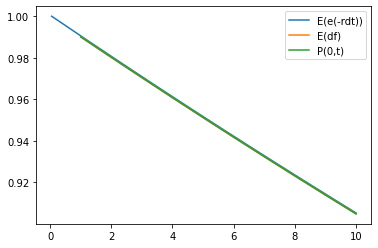

In [ ]:
import matplotlib.pyplot as plt
dt = np.concatenate([[0], times_0[1:] - times_0[:-1]], axis=0)
p_sim = np.mean(np.exp(-np.cumsum(rpaths_0 * dt, axis=1)), axis=0)
p_sim_df = tf.math.reduce_mean(paths, axis=0)
p_true = np.exp(-times * rate_fn(times))
plt.plot(times_0, p_sim, label='E(e(-rdt))')
plt.plot(times, p_sim_df, label='E(df)')
plt.plot(times, p_true, label='P(0,t)')
plt.legend()
plt.show()

In [ ]:
p_true, p_sim_df

(array([0.99004983, 0.98019867, 0.97044553, 0.96078944, 0.95122942,
        0.94176453, 0.93239382, 0.92311635, 0.91393119, 0.90483742]),
 <tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([0.99004954, 0.98019566, 0.97043916, 0.96078092, 0.95122197,
        0.94176246, 0.93239731, 0.92312755, 0.91395011, 0.9048613 ])>)

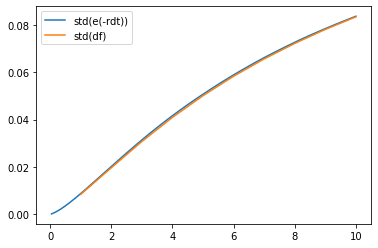

In [ ]:
dt = np.concatenate([[0], times_0[1:] - times_0[:-1]], axis=0)
p_sim = np.std(np.exp(-np.cumsum(rpaths_0*dt, axis=1)), axis=0)
p_sim_df = tf.math.reduce_std(paths, axis=0)
plt.plot(times_0, p_sim, label='std(e(-rdt))')
plt.plot(times, p_sim_df, label='std(df)')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


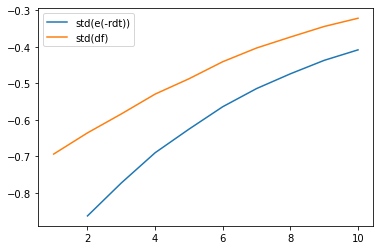

In [ ]:
dt = np.concatenate([[0], times[1:] - times[:-1]], axis=0)
rdf = -np.cumsum(rpaths*dt, axis=1)
df = np.log(paths)
p_sim, p_sim_df = (np.zeros((df.shape[1])), np.zeros((df.shape[1])))
for i, _ in enumerate(p_sim):
  p_sim[i] = np.corrcoef(rdf[:, i], xn[:, i, 1])[0][1]
  p_sim_df[i] = np.corrcoef(df[:, i], xn[:, i, 1])[0][1]
plt.plot(times, p_sim, label='std(e(-rdt))')
plt.plot(times, p_sim_df, label='std(df)')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


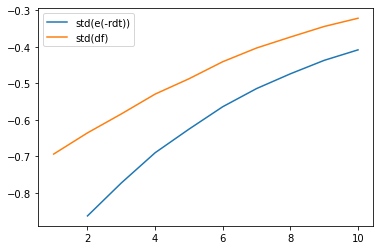

In [ ]:
dt = np.concatenate([[0], times[1:] - times[:-1]], axis=0)
rdf = -np.cumsum(rpaths*dt, axis=1)
df = np.log(paths)
p_sim, p_sim_df = (np.zeros((df.shape[1])), np.zeros((df.shape[1])))
for i, _ in enumerate(p_sim):
  p_sim[i] = np.corrcoef(rdf[:, i], xn[:, i, 1])[0][1]
  p_sim_df[i] = np.corrcoef(df[:, i], xn[:, i, 1])[0][1]
plt.plot(times, p_sim, label='std(e(-rdt))')
plt.plot(times, p_sim_df, label='std(df)')
plt.legend()
plt.show()

In [ ]:
idx = 50
np.cov(pp[:, idx] - pp[:, idx-1], xn[:, idx, 0].numpy() - xn[:, idx-1, 0].numpy())

NameError: ignored

## Test Bond sims

In [ ]:
p_t_tau, _, _ = model.sample_discount_curve_paths(
    times=times,
    curve_times=curve_times,
    num_samples=num_samples,
    time_step=0.1)
print(p_t_tau.shape)

In [ ]:
p_t_tau.shape

TensorShape([100000, 5, 10])

[0.         0.00935858 0.01857783 0.08755848 0.16292077]


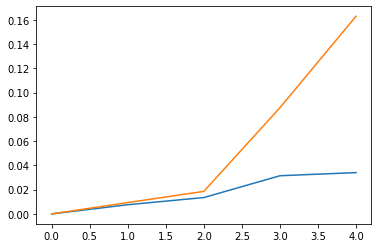

In [ ]:
def bond_std(t, T, v, k):
  eT = np.exp(-k*T)
  et = np.exp(k*t)
  #return np.sqrt(v**2/k**2 *(t-eT**2*(et**2-1.)/2/k+2*eT*(et - 1)/k))
  val = v/k * (1. - eT*et) * np.sqrt((1.-1./et/et)/k/2)
  print (val)
  return val
d = tf.math.reduce_std(tf.math.log(p_t_tau), axis=0)
tidx = 3
plt.plot(d[:,tidx])
plt.plot(bond_std(times[tidx], curve_times + times[tidx], 0.01, 0.03))

[0.         0.00933947 0.01853989 0.08737965 0.16258801]


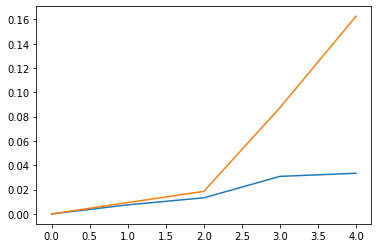

In [ ]:
d = tf.math.reduce_std(tf.math.log(p_t_tau), axis=0)
tidx = 2
plt.plot(d[:,tidx])
plt.plot(bond_std(times[tidx], curve_times + times[tidx],
                  np.sqrt(0.005**2+0.008**2+2*0.5*0.005*0.008), 0.03))

In [ ]:
aa = tf.convert_to_tensor([1,2,3])
tf.reverse(tf.expand_dims(aa, axis=0), [1])[0]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 2, 1], dtype=int32)>

## Discount bond price

In [ ]:
model.state_y([5.0]), model2.state_y([5.0])

(<tf.Tensor: shape=(2, 2, 1), dtype=float64, numpy=
 array([[[9.93262053e-05],
         [4.96631027e-05]],
 
        [[4.96631027e-05],
         [9.93262053e-05]]])>,
 <tf.Tensor: shape=(2, 2, 1), dtype=float64, numpy=
 array([[[0.00058265],
         [0.        ]],
 
        [[0.        ],
         [0.00043197]]])>)

In [ ]:
print(['%0.16f'% x for x in np.array([1, 2])])

['1.0000000000000000', '2.0000000000000000']


# Swaption pricing

In [ ]:
import enum

from tf_quant_finance.math import pde
from tf_quant_finance.models import utils
from tf_quant_finance.models import valuation_method as vm
from tf_quant_finance.models.hjm import gaussian_hjm
from tf_quant_finance.models.hjm import quasi_gaussian_hjm
from tf_quant_finance.models.hjm import swaption_util


@enum.unique
class ValuationMethod(enum.Enum):
  """Swaption valuation methods.

  * `ANALYTIC`: Analytic valuation.
  * `MONTE_CARLO`: Valuation using Monte carlo simulations.
  * `FINITE_DIFFERENCE`: Valuation using finite difference.
  """
  ANALYTIC = 1
  MONTE_CARLO = 2
  FINITE_DIFFERENCE = 3


# Points smaller than this are merged together in FD time grid
_PDE_TIME_GRID_TOL = 1e-7


def price(*,
          expiries,
          fixed_leg_payment_times,
          fixed_leg_daycount_fractions,
          fixed_leg_coupon,
          reference_rate_fn,
          num_hjm_factors,
          mean_reversion,
          volatility,
          times=None,
          time_step=None,
          num_time_steps=None,
          curve_times=None,
          corr_matrix=None,
          notional=None,
          is_payer_swaption=None,
          valuation_method=vm.ValuationMethod.MONTE_CARLO,
          num_samples=1,
          random_type=None,
          seed=None,
          skip=0,
          time_step_finite_difference=None,
          num_time_steps_finite_difference=None,
          num_grid_points_finite_difference=101,
          dtype=None,
          name=None):
  """Calculates the price of European swaptions using the HJM model.

  A European Swaption is a contract that gives the holder an option to enter a
  swap contract at a future date at a prespecified fixed rate. A swaption that
  grants the holder the right to pay fixed rate and receive floating rate is
  called a payer swaption while the swaption that grants the holder the right to
  receive fixed and pay floating payments is called the receiver swaption.
  Typically the start date (or the inception date) of the swap coincides with
  the expiry of the swaption. Mid-curve swaptions are currently not supported
  (b/160061740).

  This implementation uses the HJM model to numerically value the swaption via
  Monte-Carlo. For more information on the formulation of the HJM model, see
  quasi_gaussian_hjm.py.

  #### Example

  ````python
  import numpy as np
  import tensorflow.compat.v2 as tf
  import tf_quant_finance as tff

  dtype = tf.float64

  # Price 1y x 1y swaption with quarterly payments using Monte Carlo
  # simulations.
  expiries = np.array([1.0])
  fixed_leg_payment_times = np.array([1.25, 1.5, 1.75, 2.0])
  fixed_leg_daycount_fractions = 0.25 * np.ones_like(fixed_leg_payment_times)
  fixed_leg_coupon = 0.011 * np.ones_like(fixed_leg_payment_times)
  zero_rate_fn = lambda x: 0.01 * tf.ones_like(x, dtype=dtype)
  mean_reversion = [0.03]
  volatility = [0.02]

  price = tff.models.hjm.swaption_price(
      expiries=expiries,
      fixed_leg_payment_times=fixed_leg_payment_times,
      fixed_leg_daycount_fractions=fixed_leg_daycount_fractions,
      fixed_leg_coupon=fixed_leg_coupon,
      reference_rate_fn=zero_rate_fn,
      notional=100.,
      num_hjm_factors=1,
      mean_reversion=mean_reversion,
      volatility=volatility,
      valuation_method=tff.model.ValuationMethod.MONTE_CARLO,
      num_samples=500000,
      time_step=0.1,
      random_type=tff.math.random.RandomType.STATELESS_ANTITHETIC,
      seed=[1, 2])
  # Expected value: [[0.716]]
  ````


  #### References:
    [1]: D. Brigo, F. Mercurio. Interest Rate Models-Theory and Practice.
    Second Edition. 2007. Section 6.7, page 237.

  Args:
    expiries: A real `Tensor` of any shape and dtype. The time to expiration of
      the swaptions. The shape of this input determines the number (and shape)
      of swaptions to be priced and the shape of the output.
    fixed_leg_payment_times: A real `Tensor` of the same dtype as `expiries`.
      The payment times for each payment in the fixed leg. The shape of this
      input should be `expiries.shape + [n]` where `n` denotes the number of
      fixed payments in each leg. The `fixed_leg_payment_times` should be
      greater-than or equal-to the corresponding expiries.
    fixed_leg_daycount_fractions: A real `Tensor` of the same dtype and
      compatible shape as `fixed_leg_payment_times`. The daycount fractions for
      each payment in the fixed leg.
    fixed_leg_coupon: A real `Tensor` of the same dtype and compatible shape as
      `fixed_leg_payment_times`. The fixed rate for each payment in the fixed
      leg.
    reference_rate_fn: A Python callable that accepts expiry time as a real
      `Tensor` and returns a `Tensor` of shape `input_shape +
      [num_hjm_factors]`. Returns the continuously compounded zero rate at the
      present time for the input expiry time.
    num_hjm_factors: A Python scalar which corresponds to the number of factors
      in the HJM model to be used for pricing.
    mean_reversion: A real positive `Tensor` of shape `[num_hjm_factors]`.
      Corresponds to the mean reversion rate of each factor.
    volatility: A real positive `Tensor` of the same `dtype` and shape as
      `mean_reversion` or a callable with the following properties: (a)  The
        callable should accept a scalar `Tensor` `t` and a 1-D `Tensor` `r(t)`
        of shape `[num_samples]` and returns a 2-D `Tensor` of shape
        `[num_samples, num_hjm_factors]`. The variable `t`  stands for time and
        `r(t)` is the short rate at time `t`.  The function returns the
        instantaneous volatility `sigma(t) = sigma(t, r(t))`. When `volatility`
        is specified as a real `Tensor`, each factor is assumed to have a
        constant instantaneous volatility  and the  model is effectively a
        Gaussian HJM model. Corresponds to the instantaneous volatility of each
        factor.
    times: An optional rank 1 `Tensor` of increasing positive real values. The
      times at which Monte Carlo simulations are performed. Relevant when
      swaption valuation is done using Monte Calro simulations.
      Default value: `None` in which case simulation times are computed based
      on either `time_step` or `num_time_steps` inputs.
    time_step: Optional scalar real `Tensor`. Maximal distance between time
      grid points in Euler scheme. Relevant when Euler scheme is used for
      simulation. This input or `num_time_steps` are required when valuation
      method is Monte Carlo.
      Default Value: `None`.
    num_time_steps: An optional scalar integer `Tensor` - a total number of
      time steps during Monte Carlo simulations. The maximal distance betwen
      points in grid is bounded by
      `times[-1] / (num_time_steps - times.shape[0])`.
      Either this or `time_step` should be supplied when the valuation method
      is Monte Carlo.
      Default value: `None`.
    curve_times: An optional rank 1 `Tensor` of positive real values. The
      maturities at which spot discount curve is computed during simulations.
      Default value: `None` in which case `curve_times` is computed based on
      swaption expities and `fixed_leg_payments_times` inputs.
    corr_matrix: A `Tensor` of shape `[num_hjm_factors, num_hjm_factors]` and
      the same `dtype` as `mean_reversion`. Specifies the correlation between
      HJM factors.
      Default value: `None` in which case the factors are assumed to be
        uncorrelated.
    notional: An optional `Tensor` of same dtype and compatible shape as
      `strikes`specifying the notional amount for the underlying swaps.
       Default value: None in which case the notional is set to 1.
    is_payer_swaption: A boolean `Tensor` of a shape compatible with `expiries`.
      Indicates whether the swaption is a payer (if True) or a receiver (if
      False) swaption. If not supplied, payer swaptions are assumed.
    valuation_method: An enum of type `ValuationMethod` specifying
      the method to be used for swaption valuation. Currently the valuation is
      supported using `MONTE_CARLO` and `FINITE_DIFFERENCE` methods. Valuation
      using finite difference is only supported for Gaussian HJM models, i.e.
      for models with constant mean-reversion rate and time-dependent
      volatility.
      Default value: `ValuationMethod.MONTE_CARLO`, in which case
      swaption valuation is done using Monte Carlo simulations.
    num_samples: Positive scalar `int32` `Tensor`. The number of simulation
      paths during Monte-Carlo valuation. This input is ignored during analytic
      valuation.
      Default value: The default value is 1.
    random_type: Enum value of `RandomType`. The type of (quasi)-random number
      generator to use to generate the simulation paths. This input is relevant
      only for Monte-Carlo valuation and ignored during analytic valuation.
      Default value: `None` which maps to the standard pseudo-random numbers.
    seed: Seed for the random number generator. The seed is only relevant if
      `random_type` is one of `[STATELESS, PSEUDO, HALTON_RANDOMIZED,
      PSEUDO_ANTITHETIC, STATELESS_ANTITHETIC]`. For `PSEUDO`,
      `PSEUDO_ANTITHETIC` and `HALTON_RANDOMIZED` the seed should be an Python
      integer. For `STATELESS` and  `STATELESS_ANTITHETIC` must be supplied as
      an integer `Tensor` of shape `[2]`. This input is relevant only for
      Monte-Carlo valuation and ignored during analytic valuation.
      Default value: `None` which means no seed is set.
    skip: `int32` 0-d `Tensor`. The number of initial points of the Sobol or
      Halton sequence to skip. Used only when `random_type` is 'SOBOL',
      'HALTON', or 'HALTON_RANDOMIZED', otherwise ignored.
      Default value: `0`.
    time_step_finite_difference: Optional scalar real `Tensor`. Spacing between
      time grid points in finite difference discretization. This input is only
      relevant for valuation using finite difference.
      Default value: `None`. If `num_time_steps_finite_difference` is also
      unspecified then a `time_step` corresponding to 100 discretization steps
      is used.
    num_time_steps_finite_difference: Optional scalar real `Tensor`. Number of
      time grid points in finite difference discretization. This input is only
      relevant for valuation using finite difference.
      Default value: `None`. If `time_step_finite_difference` is also
      unspecified, then 100 time steps are used.
    num_grid_points_finite_difference: Optional scalar real `Tensor`. Number of
      spatial grid points per dimension. Currently, we construct an uniform grid
      for spatial discretization. This input is only relevant for valuation
      using finite difference.
      Default value: 101.
    dtype: The default dtype to use when converting values to `Tensor`s.
      Default value: `None` which means that default dtypes inferred by
        TensorFlow are used.
    name: Python string. The name to give to the ops created by this function.
      Default value: `None` which maps to the default name `hjm_swaption_price`.

  Returns:
    A `Tensor` of real dtype and shape expiries.shape + [1]
    containing the computed swaption prices. For swaptions that have reset in
    the past (expiries<0), the function sets the corresponding option prices to
    0.0.
  """

  # TODO(b/160061740): Extend the functionality to support mid-curve swaptions.
  name = name or 'hjm_swaption_price'
  with tf.name_scope(name):
    expiries = tf.convert_to_tensor(expiries, dtype=dtype, name='expiries')
    dtype = dtype or expiries.dtype
    fixed_leg_payment_times = tf.convert_to_tensor(
        fixed_leg_payment_times, dtype=dtype, name='fixed_leg_payment_times')
    fixed_leg_daycount_fractions = tf.convert_to_tensor(
        fixed_leg_daycount_fractions,
        dtype=dtype,
        name='fixed_leg_daycount_fractions')
    fixed_leg_coupon = tf.convert_to_tensor(
        fixed_leg_coupon, dtype=dtype, name='fixed_leg_coupon')
    notional = tf.convert_to_tensor(notional, dtype=dtype, name='notional')
    notional = tf.expand_dims(
        tf.broadcast_to(notional, expiries.shape), axis=-1)
    if is_payer_swaption is None:
      is_payer_swaption = True
    is_payer_swaption = tf.convert_to_tensor(
        is_payer_swaption, dtype=tf.bool, name='is_payer_swaption')

    output_shape = expiries.shape.as_list() + [1]
    # Add a dimension corresponding to multiple cashflows in a swap
    if expiries.shape.rank == fixed_leg_payment_times.shape.rank - 1:
      expiries = tf.expand_dims(expiries, axis=-1)
    elif expiries.shape.rank < fixed_leg_payment_times.shape.rank - 1:
      raise ValueError('Swaption expiries not specified for all swaptions '
                       'in the batch. Expected rank {} but received {}.'.format(
                           fixed_leg_payment_times.shape.rank - 1,
                           expiries.shape.rank))

    # Expected shape: batch_shape + [m], where m is the number of fixed leg
    # payments per underlying swap. This is the same as
    # fixed_leg_payment_times.shape
    #
    # We need to explicitly use tf.repeat because we need to price
    # batch_shape + [m] bond options with different strikes along the last
    # dimension.
    expiries = tf.repeat(
        expiries, tf.shape(fixed_leg_payment_times)[-1], axis=-1)

    if valuation_method == vm.ValuationMethod.FINITE_DIFFERENCE:
      model = gaussian_hjm.GaussianHJM(
          num_hjm_factors,
          mean_reversion=mean_reversion,
          volatility=volatility,
          initial_discount_rate_fn=reference_rate_fn,
          corr_matrix=corr_matrix,
          dtype=dtype)

      batch_shape = expiries.shape.as_list()[:-1] or [1]
      return _bermudan_swaption_fd(
          batch_shape,
          model,
          # Add a dimension to denote ONE exercise date
          tf.expand_dims(expiries, axis=-2),
          fixed_leg_payment_times,
          fixed_leg_daycount_fractions,
          fixed_leg_coupon,
          notional,
          is_payer_swaption,
          time_step_finite_difference,
          num_time_steps_finite_difference,
          num_grid_points_finite_difference,
          name + '_fd',
          dtype)
    elif valuation_method == vm.ValuationMethod.MONTE_CARLO:
      # Monte-Carlo pricing
      model = quasi_gaussian_hjm.QuasiGaussianHJM(
          num_hjm_factors,
          mean_reversion=mean_reversion,
          volatility=volatility,
          initial_discount_rate_fn=reference_rate_fn,
          corr_matrix=corr_matrix,
          dtype=dtype)

      return _european_swaption_mc(
          output_shape, model, expiries, fixed_leg_payment_times,
          fixed_leg_daycount_fractions, fixed_leg_coupon, notional,
          is_payer_swaption, times, time_step, num_time_steps, curve_times,
          num_samples, random_type, skip, seed, dtype, name + '_mc')
    else:
      raise ValueError('Swaption Valuation using {} is not supported'.format(
          str(valuation_method)))


def _european_swaption_mc(output_shape, model, expiries,
                          fixed_leg_payment_times, fixed_leg_daycount_fractions,
                          fixed_leg_coupon, notional, is_payer_swaption, times,
                          time_step, num_time_steps, curve_times, num_samples,
                          random_type, skip, seed, dtype, name):
  """Price European swaptions using Monte-Carlo."""
  with tf.name_scope(name):
    if (times is None) and (time_step is None) and (num_time_steps is None):
      raise ValueError(
          'One of `times`, `time_step` or `num_time_steps` must be '
          'provided for simulation based swaption valuation.')

    def _sample_discount_curve_path_fn(times, curve_times, num_samples):
      p_t_tau, r_t, df = model.sample_discount_curve_paths(
          times=times,
          curve_times=curve_times,
          num_samples=num_samples,
          random_type=random_type,
          time_step=time_step,
          num_time_steps=num_time_steps,
          seed=seed,
          skip=skip)
      p_t_tau = tf.expand_dims(p_t_tau, axis=-1)
      r_t = tf.expand_dims(r_t, axis=-1)
      df = tf.expand_dims(df, axis=-1)
      return p_t_tau, r_t, df

    payoff_discount_factors, payoff_bond_price = (
        swaption_util.discount_factors_and_bond_prices_from_samples(
            expiries=expiries,
            payment_times=fixed_leg_payment_times,
            sample_discount_curve_paths_fn=_sample_discount_curve_path_fn,
            num_samples=num_samples,
            times=times,
            curve_times=curve_times,
            dtype=dtype))

    # Add an axis corresponding to `dim`
    fixed_leg_pv = tf.expand_dims(
        fixed_leg_coupon * fixed_leg_daycount_fractions,
        axis=-1) * payoff_bond_price

    # Sum fixed coupon payments within each swap.
    # Here, axis=-2 is the payments axis - i.e. summing over all payments; and
    # the last axis is the `dim` axis, as explained in comment above
    # `fixed_leg_pv` (Note that for HJM the dim of this axis is 1 always).
    fixed_leg_pv = tf.math.reduce_sum(fixed_leg_pv, axis=-2)
    float_leg_pv = 1.0 - payoff_bond_price[..., -1, :]
    payoff_swap = payoff_discount_factors[..., -1, :] * (
        float_leg_pv - fixed_leg_pv)
    payoff_swap = tf.where(is_payer_swaption, payoff_swap, -1.0 * payoff_swap)
    payoff_swaption = tf.math.maximum(payoff_swap, 0.0)
    option_value = tf.reshape(
        tf.math.reduce_mean(payoff_swaption, axis=0), output_shape)

    return notional * option_value


def _bermudan_swaption_fd(batch_shape, model, exercise_times,
                          fixed_leg_payment_times, fixed_leg_daycount_fractions,
                          fixed_leg_coupon, notional, is_payer_swaption,
                          time_step_fd, num_time_steps_fd, num_grid_points_fd,
                          name, dtype):
  """Price Bermudan swaptions using finite difference."""
  with tf.name_scope(name):
    dim = model.dim()
    x_min = -0.5
    x_max = 0.5
    # grid.shape = (num_grid_points,2)
    grid = pde.grids.uniform_grid(
        minimums=[x_min] * dim,
        maximums=[x_max] * dim,
        sizes=[num_grid_points_fd] * dim,
        dtype=dtype)

    # TODO(b/186876306): Remove dynamic shapes.
    pde_time_grid, pde_time_grid_dt = _create_pde_time_grid(
        exercise_times, time_step_fd, num_time_steps_fd, dtype)
    maturities, unique_maturities, maturities_shape = (
        _create_termstructure_maturities(fixed_leg_payment_times))

    num_maturities = tf.shape(unique_maturities)[-1]
    x_meshgrid = _coord_grid_to_mesh_grid(grid)
    meshgrid_shape = tf.shape(x_meshgrid)
    broadcasted_maturities = tf.expand_dims(unique_maturities, axis=0)

    num_grid_points = tf.math.reduce_prod(meshgrid_shape[1:])
    shape_to_broadcast = tf.concat(
        [meshgrid_shape, [num_maturities]], axis=0)

    # Reshape `state_x`, `maturities` to (num_grid_points, num_maturities)
    state_x = tf.expand_dims(x_meshgrid, axis=-1)
    state_x = tf.broadcast_to(state_x, shape_to_broadcast)
    broadcasted_maturities = tf.broadcast_to(
        broadcasted_maturities, shape_to_broadcast[1:])

    def _get_swap_payoff(payoff_time):
      broadcasted_exercise_times = tf.broadcast_to(
          payoff_time, shape_to_broadcast[1:])

      # Zero-coupon bond curve
      zcb_curve = model.discount_bond_price(
          tf.transpose(
              tf.reshape(
                  state_x, [dim, num_grid_points * num_maturities])),
          tf.reshape(broadcasted_exercise_times, [-1]),
          tf.reshape(broadcasted_maturities, [-1]))
      zcb_curve = tf.reshape(
          zcb_curve, [num_grid_points, num_maturities])

      maturities_index = tf.searchsorted(
          unique_maturities, tf.reshape(maturities, [-1]))

      zcb_curve = tf.gather(zcb_curve, maturities_index, axis=-1)
      # zcb_curve.shape = [num_grid_points] + [maturities_shape]
      zcb_curve = tf.reshape(
          zcb_curve, tf.concat([[num_grid_points], maturities_shape], axis=0))

      # Shape after reduce_sum =
      # (num_grid_points, batch_shape)
      fixed_leg = tf.math.reduce_sum(
          fixed_leg_coupon * fixed_leg_daycount_fractions * zcb_curve, axis=-1)
      float_leg = 1.0 - zcb_curve[..., -1]
      payoff_swap = float_leg - fixed_leg
      payoff_swap = tf.where(is_payer_swaption, payoff_swap, -payoff_swap)
      return tf.reshape(tf.transpose(
          payoff_swap), tf.concat([batch_shape, meshgrid_shape[1:]], axis=0))

    def _get_index(t, tensor_to_search):
      t = tf.expand_dims(t, axis=-1)
      index = tf.searchsorted(tensor_to_search, t - _PDE_TIME_GRID_TOL, 'right')
      y = tf.gather(tensor_to_search, index)
      return tf.where(tf.math.abs(t - y) < _PDE_TIME_GRID_TOL, index, -1)[0]

    sum_x_meshgrid = tf.math.reduce_sum(x_meshgrid, axis=0)

    def _is_exercise_time(t):
      return tf.reduce_any(tf.where(
          tf.math.abs(exercise_times[..., -1] - t) < _PDE_TIME_GRID_TOL,
          True, False), axis=-1)

    def _discounting_fn(t, grid):
      del grid
      f_0_t = (model._instant_forward_rate_fn(t))  # pylint: disable=protected-access
      return sum_x_meshgrid + f_0_t

    def _final_value():
      t = pde_time_grid[-1]
      payoff_swap = tf.nn.relu(_get_swap_payoff(t))
      is_ex_time = _is_exercise_time(t)
      return tf.where(tf.reshape(is_ex_time, tf.concat(
          [batch_shape, [1] * dim], axis=0)), payoff_swap, 0.0)

    def _values_transform_fn(t, grid, value_grid):
      zero = tf.zeros_like(value_grid)
      is_ex_time = _is_exercise_time(t)
      def _at_least_one_swaption_pays():
        payoff_swap = tf.nn.relu(_get_swap_payoff(t))
        return tf.where(tf.reshape(is_ex_time, tf.concat(
            [batch_shape, [1] * dim], axis=0)), payoff_swap, zero)
      v_star = tf.cond(tf.math.reduce_any(is_ex_time),
                       _at_least_one_swaption_pays, lambda: zero)
      return grid, tf.maximum(value_grid, v_star)

    # TODO(b/186876306): Use piecewise constant func here.
    def _pde_time_step(t):
      index = _get_index(t, pde_time_grid)
      cond = lambda i, dt: tf.math.logical_and(dt < _PDE_TIME_GRID_TOL, i > -1)

      def _fn(i, dt):
        del dt
        return i + 1, pde_time_grid_dt[i + 1]

      _, dt = tf.while_loop(cond, _fn, (index, pde_time_grid_dt[index]))
      return dt

    # Use default boundary conditions, d^2V/dx_i^2 = 0
    boundary_conditions = [(None, None) for i in range(dim)]
    # res[0] contains the swaption prices.
    # res[0].shape = batch_shape + [num_grid_points] * dim
    res = model.fd_solver_backward(
        pde_time_grid[-1],
        0.0,
        grid,
        values_grid=_final_value(),
        time_step=_pde_time_step,
        boundary_conditions=boundary_conditions,
        values_transform_fn=_values_transform_fn,
        discounting=_discounting_fn,
        dtype=dtype)

    idx = tf.searchsorted(
        tf.convert_to_tensor(grid),
        tf.expand_dims(tf.convert_to_tensor([0.0] * dim, dtype=dtype), axis=-1))
    # idx.shape = (dim, 1)
    idx = tf.squeeze(idx) if dim > 1 else tf.expand_dims(idx, axis=-1)

    option_value = res[0]
    for i in range(dim - 1, -1, -1):
      option_value = tf.gather(option_value, idx[i], axis=-1)
    # output_shape = batch_shape + [1]
    return notional * tf.expand_dims(
        tf.reshape(option_value, batch_shape), axis=-1)


def _coord_grid_to_mesh_grid(coord_grid):
  if len(coord_grid) == 1:
    return tf.expand_dims(coord_grid[0], 0)
  x_meshgrid = tf.stack(values=tf.meshgrid(*coord_grid, indexing='ij'), axis=-1)
  perm = [len(coord_grid)] + list(range(len(coord_grid)))
  return tf.transpose(x_meshgrid, perm=perm)


def _create_pde_time_grid(exercise_times, time_step_fd, num_time_steps_fd,
                          dtype):
  """Create PDE time grid."""
  with tf.name_scope('create_pde_time_grid'):
    exercise_times, _ = tf.unique(tf.reshape(exercise_times, shape=[-1]))
    if num_time_steps_fd is not None:
      num_time_steps_fd = tf.convert_to_tensor(
          num_time_steps_fd, dtype=tf.int32, name='num_time_steps_fd')
      time_step_fd = tf.math.reduce_max(exercise_times) / tf.cast(
          num_time_steps_fd, dtype=dtype)
    if time_step_fd is None and num_time_steps_fd is None:
      num_time_steps_fd = 100

    pde_time_grid, _, _ = utils.prepare_grid(
        times=exercise_times,
        time_step=time_step_fd,
        dtype=dtype,
        num_time_steps=num_time_steps_fd)
    pde_time_grid_dt = pde_time_grid[1:] - pde_time_grid[:-1]
    pde_time_grid_dt = tf.concat([[100.0], pde_time_grid_dt], axis=-1)

    return pde_time_grid, pde_time_grid_dt


def _create_termstructure_maturities(fixed_leg_payment_times):
  """Create maturities needed for termstructure simulations."""

  with tf.name_scope('create_termstructure_maturities'):
    maturities = fixed_leg_payment_times
    maturities_shape = tf.shape(maturities)

    # We should eventually remove tf.unique, but keeping it for now because
    # PDE solvers are not xla compatible in TFF currently.
    unique_maturities, _ = tf.unique(tf.reshape(maturities, shape=[-1]))
    unique_maturities = tf.sort(unique_maturities, name='sort_maturities')

    return maturities, unique_maturities, maturities_shape

## Example

In [ ]:
swaption_price = price
dtype = tf.float64

expiries = np.array([1.002739726, 2.002739726])
fixed_leg_payment_times = np.array([[1.249315068,	1.498630137,	1.750684932,	2.002739726],
                                    [2.249315068,	2.498630137,	2.750684932,	3.002739726]])
fixed_leg_daycount_fractions = np.array([[0.2465753425,	0.2493150685,	0.2520547945,	0.2520547945],
                                         [0.2465753425,	0.2493150685,	0.2520547945,	0.2520547945]])
fixed_leg_coupon = 0.011 * np.ones_like(fixed_leg_payment_times)
zero_rate_fn = lambda x: 0.01 * tf.ones_like(x, dtype=dtype)

mu = [0.03, 0.15]
vol = [0.01, 0.015]


hjm_price = swaption_price(
    expiries=expiries,
    fixed_leg_payment_times=fixed_leg_payment_times,
    fixed_leg_daycount_fractions=fixed_leg_daycount_fractions,
    fixed_leg_coupon=fixed_leg_coupon,
    reference_rate_fn=zero_rate_fn,
    notional=100.,
    num_hjm_factors=len(mu),
    mean_reversion=mu,
    volatility=vol,
    # corr_matrix=[[1, 0.0], [0.0, 1]],
    valuation_method=vm.ValuationMethod.FINITE_DIFFERENCE,
    time_step_finite_difference=0.05,
    num_grid_points_finite_difference=251,
    time_step=0.05,
    num_samples=1000000,
    dtype=dtype)
hjm_price

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[0.58909314],
       [0.80141135]])>

### Using quantlib

In [ ]:
import QuantLib as ql
from QuantLib import *

frequency_enum, settle_date = 4, Date(1, 1, 2020)
expiry_date = Date(1,1,2022)
midcurve_expiry_date = Date(1,7,2020)
maturity_date = Date(1, 1, 2023)
face_amount = 100.0
settlement_days = 0
fixing_days = 0

calendar = NullCalendar()
todays_date = Date(1,1,2020)
Settings.instance().evaluationDate = todays_date

spotDates = [ql.Date(1, 1, 2020), ql.Date(1, 1, 2021), ql.Date(1, 1, 2022), ql.Date(1, 1, 2030)]
spotRates = [0.01, 0.01, 0.01, 0.01]

dayCount = ql.Actual365Fixed()
calendar = ql.UnitedStates()
interpolation = ql.Linear()
compounding = ql.Compounded
compoundingFrequency = ql.Continuous
spotCurve = ql.ZeroCurve(spotDates, spotRates, dayCount)
spotCurveHandle = ql.YieldTermStructureHandle(spotCurve)


index = IborIndex('USD Libor', Period(3, Months), settlement_days, USDCurrency(), NullCalendar(),
                  Unadjusted, False, Actual365Fixed(), spotCurveHandle)
#index.addFixing(ql.Date(15,1,2021), 0.006556)
schedule = Schedule(expiry_date,
                    maturity_date, Period(frequency_enum),
                    NullCalendar(),
                    Unadjusted, Unadjusted,
                    DateGeneration.Forward, False)

strike = 0.011
ibor_leg = ql.IborLeg([face_amount], schedule, index)
fixed_leg = ql.FixedRateLeg(schedule, Actual365Fixed(), [face_amount], [strike])

swap = ql.VanillaSwap(ql.VanillaSwap.Payer, face_amount, schedule, strike, Actual365Fixed(), schedule, index, 0.0, Actual365Fixed()) 
exercise_date = ql.EuropeanExercise(expiry_date)
swaption = ql.Swaption(swap, exercise_date)


# price using hull-white
model = ql.HullWhite(spotCurveHandle, a=0.03, sigma=0.02)
engine = ql.JamshidianSwaptionEngine(model, spotCurveHandle)
swaption.setPricingEngine(engine)
print("price using HW", swaption.NPV())

# price using G2
model = ql.G2(spotCurveHandle, a=0.03, sigma=0.01, b=0.15, eta=0.015, rho=0.0)
engine = ql.FdG2SwaptionEngine(model, 20, 500, 500)
swaption.setPricingEngine(engine)
print("price using G2", swaption.NPV())

#  additional debugging
swap.setPricingEngine(ql.DiscountingSwapEngine(spotCurveHandle))
swap.fairRate()

price using HW 1.007148261731575
price using G2 0.8029012153434956


0.010012511157488175

## Example - Time dependent vol

In [ ]:
swaption_price = price
dtype = tf.float64

expiries = np.array([1.002739726, 1.002739726])
fixed_leg_payment_times = np.array([[1.249315068,	1.498630137,	1.750684932,	2.002739726],
                                    [1.249315068,	1.498630137,	1.750684932,	2.002739726]])
fixed_leg_daycount_fractions = np.array([[0.2465753425,	0.2493150685,	0.2520547945,	0.2520547945],
                                         [0.2465753425,	0.2493150685,	0.2520547945,	0.2520547945]])
fixed_leg_coupon = 0.011 * np.ones_like(fixed_leg_payment_times)
zero_rate_fn = lambda x: 0.01 * tf.ones_like(x, dtype=dtype)

mu = [0.03, 0.15]
vol = piecewise.PiecewiseConstantFunc(
    [[0.5],[0.5]], [[0.01, 0.015], [0.015, 0.02]], dtype=dtype)


hjm_price = swaption_price(
    expiries=[expiries[0]],
    fixed_leg_payment_times=fixed_leg_payment_times[0],
    fixed_leg_daycount_fractions=fixed_leg_daycount_fractions[0],
    fixed_leg_coupon=fixed_leg_coupon[0],
    reference_rate_fn=zero_rate_fn,
    notional=100.,
    num_hjm_factors=len(mu),
    mean_reversion=mu,
    volatility=vol,
    # corr_matrix=[[1, 0.0], [0.0, 1]],
    valuation_method=ValuationMethod.MONTE_CARLO,
    time_step_finite_difference=0.05,
    num_grid_points_finite_difference=501,
    time_step=0.05,
    num_samples=2000000,
    dtype=dtype)
hjm_price

In [ ]:
vol([0.50001])

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[0.015],
       [0.02 ]])>

In [ ]:
aa = tf.ones((2,3,4))
tf.reduce_sum(aa, axis=[0, 1])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6., 6., 6., 6.], dtype=float32)>